# Upstream Regulator Analysis Package
## Randomization Testing
### Wrapper Class "Upstream" in Use

----------------------

Author: Mikayla Webster (m1webste@ucsd.edu)

Date: 1st March, 2018

----------------------

<a id='toc'></a>
## Table of Contents
1. [Background](#background)
2. [Import packages](#import)
3. [Load Networks](#load)
6. [P-value and Z-score Calculation](#pz)
8. [Display Our results](#display)

## Background
<a id='background'></a>

## Import packages
<a id='import'></a>

In [1]:
import pandas as pd
from random import shuffle
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

# import upstream regulator module
import sys
code_path = '../../ura'
sys.path.append(code_path)
import Upstream
reload(Upstream)

<module 'Upstream' from '../../ura\Upstream.pyc'>

In [2]:
%matplotlib inline

## Randomization Support Functions

In [3]:
def shuffleACopy(x):
    b = x[:] # make a copy of the keys
    shuffle(b) # shuffle the copy
    return b


def returnShuffle(its, to_shuffle):
    a = [shuffleACopy(to_shuffle) for x in range(its)]
    return a[its-1]


# modifying our usual function to support shuffled genes
def create_DEG_list(filename,
                    G,  # specify in order to add up-down info to graph
                    its = 1,
                    p_value_filter=0.05,
                    p_value_or_adj='adj',  # filtering by p-value ('p') or adjusted p-value ('adj')
                    fold_change_filter=None,  # specify a number to filter by absolute (log) fold change
                    gene_type='symbol',  # 'symbol' or 'entrez'
                    gene_column_header='gene_symbol',
                    p_value_column_header='adj_p_value',
                    fold_change_column_header='fold_change',
                    ):

    df = pd.DataFrame.from_csv(filename, sep='\t')
    
    # shuffle just the genes in this DEG file
    genes_to_shuffle = list(df['gene_symbol'])
    shuffled_genes = returnShuffle(its, genes_to_shuffle)
    shuffle_mapping = dict(zip(df['gene_symbol'], shuffled_genes))
    df['gene_symbol'] = shuffled_genes

    # remove duplicate lines for same gene symbol, just use first occurance
    df.drop_duplicates(subset=[gene_column_header], keep='first', inplace=True)
    
    # map from gene to p-value and fold change
    DEG_full_list = list(df[gene_column_header])
    DEG_to_pvalue = dict(zip(shuffled_genes, list(df[p_value_column_header])))
    DEG_to_updown = dict(zip(shuffled_genes, list(df[fold_change_column_header])))
    
    # create a graph based on the full DEG file
    DEG_full_graph = nx.DiGraph()
    DEG_full_graph.add_nodes_from(DEG_full_list)  
    nx.set_node_attributes(DEG_full_graph, values = DEG_to_pvalue, name = 'adj_p_value')
    
    nx.set_node_attributes(DEG_full_graph, values = DEG_to_updown, name = 'updown')
    
    # filter by p-value cut-off
    df = df.loc[df[p_value_column_header] < p_value_filter]

    # filter by (log) fold change cut off if applicable
    if fold_change_filter != None:
        df = df.loc[abs(df[fold_change_column_header]) > fold_change_filter]
        
    # save just significant values
    DEG_list = list(df[gene_column_header])
        
    # add up-down info to DG_TF
    small_updown_dict = {n:DEG_to_updown[n] if n in DEG_to_updown else 0 for n in G.nodes()}
    nx.set_node_attributes(G, values = small_updown_dict, name = 'updown')

    return DEG_list, DEG_to_pvalue, DEG_to_updown, DEG_full_graph, G


def create_mega_list(ura, filename, iters, p_value_filter):
    
    # init mega list
    ura.DEG_list, ura.DEG_to_pvalue, ura.DEG_to_updown, ura.DEG_full_graph, DG_TF = create_DEG_list(filename, 
                                                                                                ura.DG_TF, 
                                                                                                p_value_filter=p_value_filter)
    z_scores_mega_list = pd.DataFrame(index=ura.z_scores.index)
    ura.tf_zscore(bias_filter=0.25)
    z_scores_mega_list[str(0)] = pd.Series(ura.z_scores)
    
    # generate random z-score shuffles
    for i in range(iters):
        ura.DEG_list, ura.DEG_to_pvalue, ura.DEG_to_updown, ura.DEG_full_graph, DG_TF = create_DEG_list(filename, 
                                                                                                ura.DG_TF, 
                                                                                                p_value_filter=p_value_filter)
        ura.tf_zscore(bias_filter=0.25)
        z_scores_mega_list[str(i+1)] = pd.Series(ura.z_scores)
    
    return z_scores_mega_list
    

## Arthritis

In [4]:
# User preferences
symbol = 'symbol'
entrez = 'entrez'

human = 'human'
mouse = 'mouse'

ura = Upstream.Upstream(gene_type = symbol, species = human)

### Calculate z-scores normally

First, let's look at which transcription factors are most significant according to our URA package.

In [5]:
# transcription factors
ura.easy_load_TF_list(slowkow_bool=True, jaspar_bool=True)

# background network
filename = "../../background_networks/9606.protein.actions.v10.5.txt"
confidence_filter = 400
ura.load_STRING_to_digraph(filename, confidence_filter);

# DEG list
DEG_filename = "../../DEG_databases/DE_Coeff_OAvsNormal_OAvsNormal_20171215.csv" 
ura.create_DEG_list(DEG_filename, p_value_filter = 0.05, fold_change_filter = 1)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-7374...done.
Finished.
56 input query terms found dup hits:
	[(u'ENSP00000359550', 3), (u'ENSP00000447879', 2), (u'ENSP00000364076', 2), (u'ENSP00000348986', 2),
312 input query terms found no hit:
	[u'ENSP00000376684', u'ENSP00000289352', u'ENSP00000202788', u'ENSP00000373637', u'ENSP00000367802',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [6]:
ura.tf_zscore(bias_filter=0.25)
top_values = ura.top_values(act=True, abs_value=True, top=5)
display(top_values)

,z-score,(adj) p-value,(log) fold change
STAT1,2.840188,0.826469,0.063822
CENPA,2.672612,NaN,NaN
FOXO3,-2.710687,0.000292,-1.125810
GLI2,-2.828427,0.172742,-0.554695
RBL2,-3.162278,0.129498,-0.830733


### Calculate randomized z-scores

Now let's see how significant these same TF's are in a randomized graph.

Takes about 45 seconds per iteration, so you may need to be patient!

In [7]:
filename = "../../DEG_databases/DE_Coeff_OAvsNormal_OAvsNormal_20171215.csv" 
iters = 1000
p_value_filter = 0.05

mega_list = create_mega_list(ura, filename, iters, p_value_filter)

In [8]:
# z-scores for each iteration, using a different shuffled DEG list each time
#mega_list.loc[top_values.index]

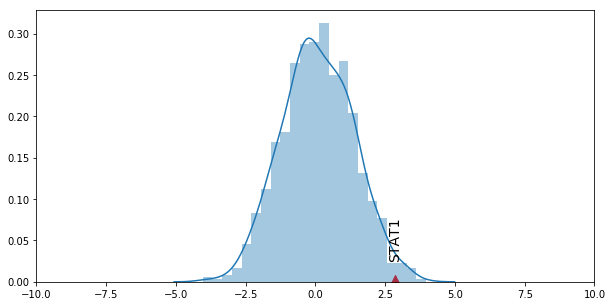

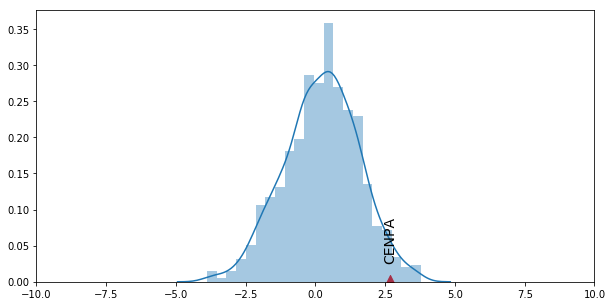

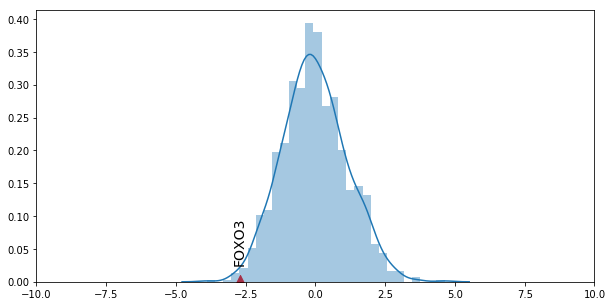

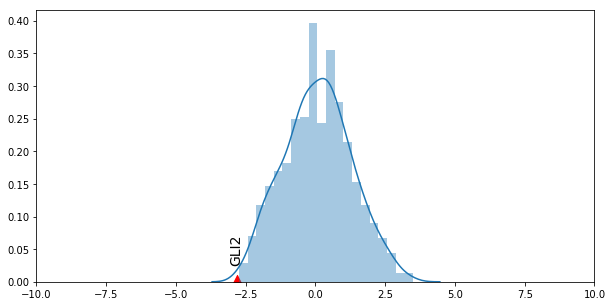

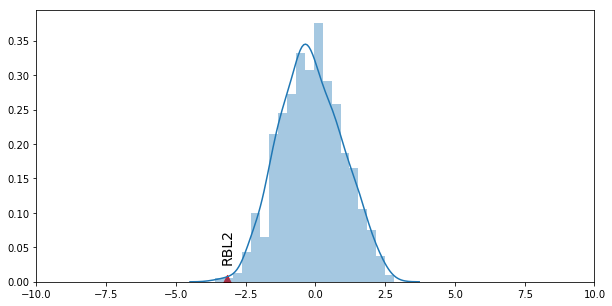

In [9]:
for i in range(len(top_values)):
    TF = mega_list.loc[top_values.index].index[i]
    TF_normal_z = top_values["z-score"][TF]
    plt.figure(figsize=(10, 5))
    plt.xlim((-10,10)) # adjust the max leaving min unchanged
    ax = sns.distplot(list(mega_list.loc[top_values.index[i]]), kde=True)
    plt.scatter([TF_normal_z], [0], marker='^', s=200, c='r')
    ax.annotate(TF, xy=(TF_normal_z, 0.025),
                        rotation=90,
                        horizontalalignment='center',
                        verticalalignment='bottom',
                        fontsize=14)

## Breast Cancer

In [10]:
# User preferences
symbol = 'symbol'
entrez = 'entrez'

human = 'human'
mouse = 'mouse'

urb = Upstream.Upstream(gene_type = symbol, species = human)

In [11]:
# transcription factors
urb.easy_load_TF_list(slowkow_bool=True, jaspar_bool=True)
TF_list = urb.get('TF_list')
TF_list = TF_list + ['TNF', 'IFNG', 'LBP'] # known regulators of interest missing from our TF databases
urb.set('TF_list', TF_list)

# background network
filename = "../../background_networks/9606.protein.actions.v10.5.txt"
confidence_filter = 400
urb.load_STRING_to_digraph(filename, confidence_filter);

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-7374...done.
Finished.
56 input query terms found dup hits:
	[(u'ENSP00000359550', 3), (u'ENSP00000447879', 2), (u'ENSP00000364076', 2), (u'ENSP00000348986', 2),
312 input query terms found no hit:
	[u'ENSP00000376684', u'ENSP00000289352', u'ENSP00000202788', u'ENSP00000373637', u'ENSP00000367802',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [12]:
# add DEG information to STRING background network
filename_brca = '../../DEG_databases/geo2r_GSE11352_brca_48hours.txt'
urb.create_DEG_list(filename_brca, p_value_filter = 0.05)

In [ ]:
urb.tf_zscore(bias_filter=0.25)
top_values = urb.top_values(act=True, abs_value=True, top=5)
top_values

,z-score,(adj) p-value,(log) fold change
STAT1,1.732051,0.6421,0.136488
MYCN,1.732051,0.0545,-3.033888
STAT3,1.732051,0.3654,-0.324608
MYC,1.666667,0.1006,0.807643
TP53,-1.889822,0.6567,0.131119


In [ ]:
iters = 1000
p_value_filter = 0.05

mega_list = create_mega_list(urb, filename_brca, iters, p_value_filter)

In [ ]:
# z-scores for each iteration, using a different shuffled DEG list each time
#mega_list.loc[top_values.index]

In [ ]:
for i in range(len(top_values)):
    TF = mega_list.loc[top_values.index].index[i]
    TF_normal_z = top_values["z-score"][TF]
    plt.figure(figsize=(10, 5))
    plt.xlim((-10,10)) # adjust the max leaving min unchanged
    ax = sns.distplot(list(mega_list.loc[top_values.index[i]]), kde=True)
    plt.scatter([TF_normal_z], [0], marker='^', s=200, c='r')
    ax.annotate(TF, xy=(TF_normal_z, 0.025),
                        rotation=90,
                        horizontalalignment='center',
                        verticalalignment='bottom',
                        fontsize=14)